### HashBeam: Enabling Feedback Through Downlink Beamforming in Unsourced Random Access
Jamison R. Ebert, Krishna R. Narayanan, Jean-Francois Chamberland

https://arxiv.org/abs/2206.01684

In [1]:
from numpy import abs, sqrt, pi, eye, array, dot, log10, exp, mean, cov, zeros, vstack, ones, log
from numpy.random import rand, randn, randint, permutation
from numpy.linalg import inv, norm, det
from scipy.special import erfc
import matplotlib.pyplot as plt

In [2]:
def simulate(K, M, L, nvar, alpha, A_qda, b_qda, c_qda, threshold):
    """
    Simulate HashBeam downlink beamforming. 
    
        Parameters:
            K (int): Number of successfully decoded users
            M (int): Number of antennas at the base station
            L (int): Length of hash
            nvar (float): variance of complex AWGN
            alpha (float): scaling of hash entries
            A_qda (ndarray): matrix A for QDA
            b_qda (ndarray): vector b for QDA
            c_qda (float): scalar c for QDA
            threshold (float): threshold for QDA
        
        Returns:
            num_md (int): Number of observed missed detections
            num_fa (int): Number of observed false alarms
            good_thetas (list): list of thetas (test statistics)
                                corresponding to successfully decoded users
            bad_theta (float): theta corresponding to unsuccessfully decoded user
            avg_snr (float): average SNR of successfully decoded users
        
    """

    # Generate channel vectors for successfully decoded users. 
    # Channels are independent quasi-static Rayleigh fading channels
    H = sqrt(1/2)*(randn(M, K) + 1j*randn(M, K)) 
    
    # Generate hashes of length L for successfully decoded users. 
    # In practice, these hashes will be generated based on decoded uplink messages
    A = alpha*exp(1j*2*pi*rand(L, K))

    # Compute Khatri-Rao product of A and H. 
    S = vstack([A[i, :] * H for i in range(L)])

    # Use uplink-downlink duality to compute downlink beamforming vectors.
    W_lmmse = inv(alpha**2*nvar*eye(K) + S.conj().T@S)@S.conj().T

    # Model ACKs as a vector of all ones.
    x = ones(K).reshape(1, -1)
    
    # Compute signal to transmit from base station to user equipments. 
    # This signal is of length LM and will be sent using M antennas
    # across L channel uses. 
    v = (x @ W_lmmse).flatten()
    
    # Store appropriate error values
    num_md, num_fa = 0, 0
    good_thetas = []
    avg_snr = 0.0
    
    # Compute empirical rate of missed detection for successfully
    # decoded users. 
    for idxusr in range(K):
        
        # Generate user i's noise vector
        zi = sqrt(nvar/2)*(randn(L) + 1j*randn(L))
        
        # At every transmission time instant, user i receives the inner 
        # product of the signal sent across the base station's M antennas
        # and the user's channel, plus noise. 
        ri = array([dot(H[:, idxusr], v[i*M:(i+1)*M]) for i in range(L)])
        
        # Compute user's SNR.
        avg_snr += 10*log10(norm(ri)**2 / norm(zi)**2)/K
        
        # Add noise to user i's received signal. 
        ri = ri + zi
        
        # User correlates received signal with hash
        theta = dot(ri, A[:, idxusr])
        good_thetas.append(theta) 

        # Check for missed detection
        x = array([theta.real, theta.imag]).reshape(-1, 1)
        if x.T@A_qda@x + b_qda.T@x + c_qda < 0:
            num_md += 1
            
    # We now consider another user whose uplink message was not successfully
    # decoded. We will check to see if this user suffers from a false alarm.
    
    # Generate channel and hash vectors for this user
    hi = sqrt(1/2)*(randn(M) + 1j*randn(M)) 
    ai = alpha*exp(1j*2*pi*rand(L))
    
    # Compute user i's received signal.
    zi = sqrt(nvar/2)*(randn(L) + 1j*randn(L))
    ri = array([dot(hi, v[i*M:(i+1)*M]) for i in range(L)]) 
    ri += zi
    
    # Correlate with hash.
    bad_theta = dot(ri, ai)

    # Check for false alarm.
    x = array([bad_theta.real, bad_theta.imag]).reshape(-1, 1)
    if x.T@A_qda@x + b_qda.T@x + c_qda > 0:
        num_fa += 1
        
    # return error results
    return num_md, num_fa, good_thetas, bad_theta, avg_snr

In [3]:
def compute_qda_parameters(good_thetas, bad_thetas):
    """
    Compute QDA parameters. 
    
        Parameters:
            good_thetas (list): list of thetas corresponding to successfully
                                decoded users
            bad_thetas (list): list of thetas corresponding to unsuccessfully
                               decoded users
        
        Returns:
            A_qda (ndarray): matrix portion of quadratic discriminant
            b_qda (ndarray): vector portion of quadratic discriminant
            c_qda (ndarray): scalar portion of quadratic discriminant
    """
    # Separate real and imaginary parts of all parameters
    good_thetas_2d = array([array([theta.real, theta.imag]) 
                               for theta in good_thetas])
    bad_thetas_2d = array([array([theta.real, theta.imag])
                              for theta in bad_thetas])

    # Compute class-specific means and covariances
    mu0 = mean(bad_thetas_2d, axis=0).reshape(-1, 1)
    cov0 = cov(bad_thetas_2d, rowvar=False)
    mu1 = mean(good_thetas_2d, axis=0).reshape(-1, 1)
    cov1 = cov(good_thetas_2d, rowvar=False)

    # Compute covariance inverses only once
    cov0_inverse = inv(cov0)
    cov1_inverse = inv(cov1)
    
    # Define offset. This offset allows Pr(MD) and Pr(FA) to be manually traded off. 
    # In our paper, we used a Neyman-Pearson approach and set Pr(MD) to be 0.05. 
    # If the ensuing Pr(FA) was greater than 0.05, we incremented L. 
    offset = -0.9444616088408512 

    # Compute quadratic discriminant parameters
    A_qda = 0.5*(cov0_inverse - cov1_inverse)
    b_qda = (cov1_inverse @ mu1) - (cov0_inverse @ mu0)
    c_qda = 0.5*(mu0.T @ cov0_inverse @ mu0 - mu1.T @ cov1_inverse @ mu1) \
            + 0.5*log(det(cov0)/det(cov1)) \
            + offset
            
    return A_qda, b_qda, c_qda

In [4]:
# Simulation parameters
K = 10                 # number of successfully decoded users
M = 20                 # number of antennas at the base station
L = 3                  # length of each user's hash
alpha = 1.35
nvar = 0.01 

# Initialize discriminant parameters to uninformative values. 
# When QDA parameters are unknown, the simulation may be run in 
# order to generate many good and bad thetas. 
# Given this data set of thetas, the optimal discriminant may then
# be computed
A_qda = zeros((2, 2))
b_qda = zeros(2).reshape(-1, 1)
c_qda = 0
threshold = 0

In [7]:
# Error tracking parameters
num_sims = 10000
pr_md = 0.0
pr_fa = 0.0
idx_sim = 0
good_thetas = []
bad_thetas = []
avg_snr = 0.0

# Empirically estimate the rates of missed detection and false alarm
while idx_sim < num_sims:
    num_md, num_fa, gthetas, btheta, avg_snr_sim = simulate(K, M, L, nvar, alpha, A_qda, b_qda, c_qda, threshold)
    pr_md += num_md
    pr_fa += num_fa
    avg_snr += avg_snr_sim
    for t in gthetas: 
        good_thetas.append(t)
    bad_thetas.append(btheta)
    idx_sim += 1
    
# Normalize results to get valid probability
pr_md /= (idx_sim*K)
avg_snr /= idx_sim
pr_fa /= idx_sim

# Print results
print('L: ' + str(L) + ' alpha: ' + str(alpha))
print('Average SNR: ' + str(avg_snr))
print('Pr(FA): ' + str(pr_fa))
print('Pr(MD): ' + str(pr_md))

L: 3 alpha: 1.35
Average SNR: 9.95825799683285
Pr(FA): 0.0221
Pr(MD): 0.02844


In [6]:
A_qda, b_qda, c_qda = compute_qda_parameters(good_thetas, bad_thetas)

(-1.615544689527067,
 1.8441371300949683,
 -1.6064917124148792,
 1.8531901072071562)

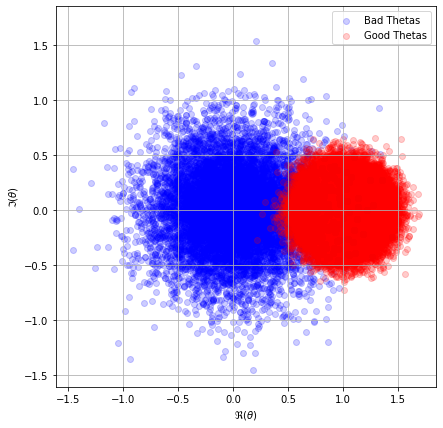

In [9]:
# Optional plotting of decision statistics
plt.rcParams['figure.figsize'] = [7, 7]
good_thetas_np = array([good_thetas]).flatten()
bad_thetas_np = array([bad_thetas]).flatten()
plt.figure()
plt.scatter(bad_thetas_np.real, bad_thetas_np.imag, alpha=0.2, c='blue', label='Bad Thetas')
plt.scatter(good_thetas_np.real, good_thetas_np.imag, alpha=0.2, c='red', label='Good Thetas')
plt.grid(True, which='both')
plt.legend()
plt.xlabel(r'$\Re(\theta)$')
plt.ylabel(r'$\Im(\theta)$')
plt.axis('square')